# Data Processing Revised

This code should format the data found here: 

layers: https://drive.google.com/drive/folders/1oSKJE9uN5-v2tezvFBCyYbp-0mH9psDd

debug plots: https://drive.google.com/drive/folders/1oGhKprLL1WvcVUkzf1ZgMnG6TTgnwsui

to be able to featureize the data later


In [1]:
import cv2 as cv
import NDH_Tools as ndh
import glob

import numpy as np
from scipy.fft import fft
import cv2 as cv
import scipy.optimize as spopt
from scipy.interpolate import CubicSpline 
from skimage.filters import gaussian, threshold_otsu
from skimage import measure
import matplotlib.pyplot as plt



In [14]:
# Try to add unqiue layer numbers
# Gets the individual layers picked in the GT
def getGTLayerLines(shape, rot_layer_elevs):
    # print(shape)
    layers_dim = np.zeros(shape)
    # print(layers_dim.shape)
    split_layers_x = []
    split_layers_y = []
    split_layers_num = []
    k = 1
    # rot_layer_elevs = np.rot90(rot_layer_elevs,k=3)
    r, c = rot_layer_elevs.shape
    print(r)
    for i in range(r):
        layer = rot_layer_elevs[i,:]

        # get the x/col index of the elevation data
        elevs = np.where(~(layer == 0))[0]
        # print(elevs)

        if not (elevs).all():
            continue

        # find the indexes of splits in a layer
        try_detect = [i+1 for i in range(len(elevs)-1) if elevs[i]+1 != elevs[i+1]]
        # print(try_detect)
        # split the columns up - now have col/x indexes of the elevations
        sply = np.split(elevs, try_detect)
        # print(len(sply))
        # only record if there are splits
        if sply:
            # We can now get the elevataion values (y/row)
            for s in sply:
                split_layers_x.append(s)
                split_layers_y.append(layer[s]) 
                split_layers_num.append(k)
                k +=1


    return split_layers_x, split_layers_y, split_layers_num


def getGTLayers(log_data, rot_layer_elevs, a, b, c, d):

    ldim_x, ldim_y, layernum = getGTLayerLines(log_data.shape,rot_layer_elevs)
    layers_dim = np.zeros_like(log_data)
    plt.close()
    # plt.imshow(log_data, cmap='Greys')
    for x,y,n in zip(ldim_x, ldim_y, layernum):
        plt.plot(x,((y-c) * ( (b-a) / (d-c) )), color='b', alpha=0.2)
        # layers_dim[y, x] = 1
        layers_dim[((y-c) * ( (b-a) / (d-c) )).astype(int), x] = n

    return layers_dim
    

# OKAY ! TRY GO GET ALL DATA TOGETHER!

In [28]:
def getLayerOverlay(name, log_data, layers):
    # ldim_x, ldim_y, _ = getGTLayerLines(log_data.shape, layers)
    # plt.subplot(121),plt.imshow(log_data, cmap='Greys')
    # plt.subplot(122),plt.imshow(layers, cmap='Greys')

    ## Get the equations for every layer in the image
    # Calculate all the derivative of the splines
    # shift = 100
    slice_labels = layers# cv.connectedComponents(np.uint8(GT_layers))
    label_values = np.unique(slice_labels)[1:] #remove the 0 label
    num_labels = len(label_values)
    splines = []
    domains = []
    # derivs = []

    print("labels: ", num_labels)

    for label_num in label_values:
        # isolate the label and skeletonize so that label is 1
        label_skeleton = (slice_labels[:,:] == label_num).astype(int)
        
        # Get every x,y every 10 columns
        row, col = label_skeleton.shape
        col_check = np.arange(0, col, 10)

        x, y = [], []
        for c in col_check:
            for r in range(row):
                if label_skeleton[r,c] == 1:
                    if c in x: continue # if there are two lines then only take the top
                    x.append(c) # get x indices
                    y.append(r) # get y indices

        # create the cubic spline for the label
        if(len(x) > 1 and len(y) > 1):
            splines.append(CubicSpline(x,y))
            domains.append(x)
            # derivs.append(splines[-1].derivative())

        # reset for next loop
        x = []
        y = []
    # display all splines
    plt.close()
    x = np.arange(0, layers.shape[1], 10)
    fig_cs, ax = plt.subplots(figsize=(9,6))
    ax.imshow(log_data, cmap="binary")#, vmin=-50, vmax=-15) # if we want to see the image underneath
    for i in range(len(domains)):
        ax.plot(domains[i], splines[i](domains[i]), label = str(i), alpha=0.2, color='b')
    ax.axis('off')
        
    plt.savefig("Seg_Layers/Bayu_"+name, bbox_inches='tight', pad_inches=0.0)

In [26]:
# Modified/debugged quality metrics

def spatialFrequency(labels, splines, spatial_freq, wid):
    shaded_norms = (labels > 0).astype(int) 
    row, col = shaded_norms.shape
    # wid = 10
    s=0
    for spl in spatial_freq:
        for ((dist, ps),x) in spl:
            for i in range(x,x+wid):
                if i < col:
                    y = int(np.floor(splines[s](i)))
                    if y >= row: y = row-1 #cap at the max row
                    yo = int(y - 1)
                    # print(type(y), type(yo), type(i))
                    while yo >=0 and shaded_norms[yo, i] == 0:
                        yo -= 1
                    # yo = int(splines[ps](i))
                    if yo < 0:
                        yo = 0
                    shaded_norms[yo:y, i] = dist
        s +=1
    # Now we have an arrya with the distances filled in between layer
    # plt.imshow(shaded_norms, cmap='Greens')
    # return shaded_norms
    # We need to isolate the surface and the bedrock so we can remove those areas from the frequency
    #https://stackoverflow.com/questions/19125661/find-index-where-elements-change-value-numpy
    surface_borders = []
    bedrock_borders = []
    # print(shaded_norms.shape, shaded_norms.T.shape)
    for col in shaded_norms.T:
        chg_pts = np.where(col[:-1] != col[1:])[0] 
        # if there are no changes in a column then just put 0s
        if not len(chg_pts):  
            surface_borders.append(0)
            bedrock_borders.append(0)
            continue
        surface_borders.append(chg_pts[0])
        bedrock_borders.append(chg_pts[-1])

    # Calculate frequency along columns
    X = []
    freq = []
    i = 0
    for col in shaded_norms.T:
        # check if empty row
        if col[surface_borders[i]:bedrock_borders[i]].size:
            col_fft =np.abs(fft(col[surface_borders[i]:bedrock_borders[i]]))
            # print("len colfft", len(col_fft))
            X.append(col_fft[len(col_fft)//2:])
            N = len(col_fft[len(col_fft)//2:])
            freq.append(1./np.linspace(0, N, N))
            # X[:(len(col_fft)-len(col_fft)//2), i] = col_fft[len(col_fft)//2:]
            # N = len(col_fft[len(col_fft)//2:])
            # freq[:N, i] = 1./np.linspace(0, N, N)    
            i += 1
    
    return X, freq, shaded_norms


def getBreakPoints(domains, splines, radar_rows, radar_wid, wid):
    i = 0
    num = 0
    # print(radar_rows, radar_wid)
    break_points = np.zeros((radar_rows, radar_wid))
    # print(break_points.shape)
    # print(radar_rows, radar_wid, radar_wid-wid)
    for dom in domains:
        # Check for a layer starting in the middle
        if int(dom[0]) > int(wid) and int(dom[0]) < int(radar_rows) and int(splines[i](dom[0])) < radar_wid:
            break_points[int(dom[0]),int(splines[i](dom[0]))] = 1
            num +=1
        # Check for a layer ending in the middle
        if int(dom[-1]) > int(wid) and int(dom[-1]) < int(radar_rows-wid) and int(splines[i](dom[-1])) < radar_wid:
            break_points[int(dom[-1]), int(splines[i](dom[-1]))] = 1
            num +=1
        i += 1
    return break_points, num



def distanceBetweenLayer(splines, domains, derivs, labelshape, wid):
    # For every 10 pixels in the original image, calculate the normal line and check which spline above it it intersects.
    # EPSILON = 0.5
    # nl_domain = 50000 # this has to be huge for the bisect to work
    x, y = labelshape
    nl_domain = int(np.sqrt(x*x +y*y) + 100) # this has to be huge for the bisect to work - larger than the hypotenus of the image
    i=0
    x= y =0
    # wid = 10
    # for each spline from 1 to the end
    s = 0
    spatial_freq = []

    for spline in splines:
        dist_per_spline = []
        # every 2 px calc the normal
        dom_px2 = np.arange(domains[s][0], domains[s][-1], wid)
        # for the the domain of the spline
        for xo in dom_px2:
            #  print("xo: ", xo)
            dist = [] #reset for the next loop
            # eval the derviative - m
            tangent_slope = derivs[s](xo)
            yo = spline(xo)

            # If the tangent is flat
            if tangent_slope == 0:
                # norm_slope = -1/tangent_slope
                norm_slope = 1000000  # its vertical so just make it huge for now - TODO - can be fixed
                maxnx = 0
                minnx = 0
            # Tangent posative - norm negative
            elif tangent_slope > 0: 
                norm_slope = -1/tangent_slope
                minnx = xo 
                maxnx = xo + nl_domain
            # Tangent negative - norm posative
            elif tangent_slope < 0:
                norm_slope = -1/tangent_slope
                minnx = xo - nl_domain
                maxnx = xo

            # for every spline above the current spline 
            prev_s = 0
            
            for prev_spline in splines:
                # print("maxnx:", maxnx)
                if prev_spline == spline: continue

                # If the spline is below then skip 
                if int(prev_spline(xo)) > yo:  continue

                # difference function, its zero marks the intersection
                f = lambda x: prev_spline(x) - (norm_slope * x - norm_slope * xo +yo) 

                try:
                    # find root via bisection
                    x = spopt.bisect(f, a = max(domains[prev_s][0], minnx), b = min(domains[prev_s][-1], maxnx)) 
                except ValueError:
                    i += 1
                    # continue

                # calculate the distance from the orginal spline to the prev_spline
                y = prev_spline(x).astype(float)
                d = np.sqrt((xo - x)*(xo - x)+(yo - y)*(yo - y))
                # print(dx2, dy2 ,d)
                dist.append( (d, prev_s) )
                # Update the index for the next spline
                prev_s +=1 
                # END for prev_spline in splines[:s]

            # get the min distance and the point
            if dist != []:
                # min on the first index of the tuple and the xo its at - (dist, prev_spline#, xo)
                dist_per_spline.append((min(dist), xo)) 
            dist = []
            # END for xo in domains[s]
            
        # get the min of the roots 
        spatial_freq.append(dist_per_spline) # 1 row per spline[1:] with - dist, prev_spline#, xo at the spline
        dist_per_spline = []
        s += 1

        # End FOR SPLINE IN SPLINES[1:]
        # print(i)
    return spatial_freq



# Returns connected_components, orientation, break_points, spatial_frequencies, dist_map, mean_orientation
def getFeatures(image, column_overlap = 10, row_overlap = 10):
    
    connected_components = []
    orientation = []
    break_points = []
    spatial_frequencies = []
    
    # calculate the bounds of the image
    sr, er = 0,image.shape[0]
    sc, ec = 0,image.shape[1]
    # generate the window bounds
    columns = np.arange(0,ec-sc+column_overlap,column_overlap)
    rows = np.arange(0,er-sr+row_overlap,row_overlap)
    # get the number of windows created
    num_row = rows.shape[0]-2
    num_col = columns.shape[0]-2
    
    
    connected_components_per_image = np.zeros((num_row,num_col), dtype=float)
    # orientation_per_image = np.zeros((num_row,num_col), dtype=float)
    
    orient_per_window = []
    mean_orientation = np.zeros((num_row,num_col), dtype=float)
    for r in range(num_row):
        for c in range(num_col):
            
            # Calculate the connected components
            connected_components_per_image[r,c]= cv.connectedComponents(image[rows[r]:rows[r+2],columns[c]:columns[c+2]])[0]
            
            # Calculate the orientation
            blurred = gaussian(image[rows[r]:rows[r+2],columns[c]:columns[c+2]], sigma=.8)
            binary = blurred > threshold_otsu(blurred)
            labels = measure.label(binary)
            
            props = measure.regionprops(labels)
            for prop in props:
                orient_per_window.append(prop.orientation)
            if(len(orient_per_window) == 0):
                  mean_orientation[r,c] =0
            else:
                #print(statistics.mean(orient))
                mean_orientation[r,c] = np.mean(orient_per_window)
            orient_per_window = [] # reset for next loop
           
    # record the connected components for each image
    connected_components.append(connected_components_per_image)
    # record the orientation for each image
    orientation.append(mean_orientation)
    
    # generate the number of layer with labels = measure.label(binary)
    blurred = gaussian(image, sigma=.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    props = measure.regionprops(labels) # len(props) give the number of labels identified
    
    # caclulate the splines for the layers
    label_values = np.unique(labels)[1:] #remove the 0 label
    num_labels = len(label_values)
    splines = []
    domains = []
    derivs = []
    # get the equations for the lines
    for label_num in label_values:
        # isolate the label and skeletonize so that label is 1
        label_skeleton = (image[:,:] == label_num).astype(int)
        
        # Get every x,y every 10 columns
        row, col = label_skeleton.shape
        col_check = np.arange(0, col, 10)

        x, y = [], []
        for c in col_check:
            for r in range(row):
                if label_skeleton[r,c] == 1:
                    if c in x: continue # if there are two lines then only take the top
                    x.append(c) # get x indices
                    y.append(r) # get y indices

        # create the cubic spline for the label
        if(len(x) > 1 and len(y) > 1):
            splines.append(CubicSpline(x,y))
            domains.append(x)
            derivs.append(splines[-1].derivative())

        # reset for next loop
        x = []
        y = [] 

    # calc the spatial frequency 
    wid = 10
    distances = distanceBetweenLayer(splines, domains, derivs, labels.shape, wid)
    X, Freq, shaded_norms = spatialFrequency(labels, splines, distances, wid)
    # shaded_norms = spatialFrequency(labels, splines, distances, wid)
    # spatial_frequencies = (X, Freq)
    
    # Get the break points in layers
    break_points, num_bp = getBreakPoints(domains, splines, labels.shape[0], labels.shape[1], wid)

    return  connected_components, orientation, break_points, num_bp, shaded_norms, mean_orientation, splines, domains, X, Freq  #spatial_frequencies,

In [11]:
# check we have all the layers and ra data in corresonding lists

# GT
# Layer_folder = "Layer_Data2/"
# Data_folder = "Raw_Data2/"
# labels_name = 'Layer_*.mat' 
# layer_pre ="Layer_Data2\\Layer_"
# data_pre ="Raw_Data2\\"

# Bayu
Layer_folder = "Layers_Data/"
Data_folder = "Raw_Data/"
labels_name = 'LAYERS-*.mat' 
layer_pre ="Layers_Data\\LAYERS-"
data_pre ="Raw_Data\\"

data_name = "Data*.mat"


layer_fns = sorted(glob.glob(Layer_folder+labels_name))
data_fns = sorted(glob.glob(Data_folder+data_name))

print(len(layer_fns), layer_fns)
print(len(data_fns), data_fns)
# Currently we have more raw data than picked layers - get the matching ones
data_fns_matching=[]
for df in data_fns:
    if layer_pre+df[len(data_pre):] in layer_fns:
        data_fns_matching.append(df)

print(len(data_fns_matching), data_fns_matching)
# print(layer_fns[-7:])

6 ['Layers_Data\\LAYERS-Data_20120418_01_042.mat', 'Layers_Data\\LAYERS-Data_20120516_01_081.mat', 'Layers_Data\\LAYERS-Data_20120516_01_082.mat', 'Layers_Data\\LAYERS-Data_20120516_01_088.mat', 'Layers_Data\\LAYERS-Data_20120516_01_089.mat', 'Layers_Data\\LAYERS-Data_20120516_01_090.mat']
6 ['Raw_Data\\Data_20120418_01_042.mat', 'Raw_Data\\Data_20120516_01_081.mat', 'Raw_Data\\Data_20120516_01_082.mat', 'Raw_Data\\Data_20120516_01_088.mat', 'Raw_Data\\Data_20120516_01_089.mat', 'Raw_Data\\Data_20120516_01_090.mat']
6 ['Raw_Data\\Data_20120418_01_042.mat', 'Raw_Data\\Data_20120516_01_081.mat', 'Raw_Data\\Data_20120516_01_082.mat', 'Raw_Data\\Data_20120516_01_088.mat', 'Raw_Data\\Data_20120516_01_089.mat', 'Raw_Data\\Data_20120516_01_090.mat']


# FOR GT DATA

Layer_Data2\Layer_Data_20120330_01_004.mat Raw_Data2\Data_20120330_01_004.mat
8
#
##
###
####
#####
######
#######
########
#########
##########
Layer_Data2\Layer_Data_20120330_01_005.mat Raw_Data2\Data_20120330_01_005.mat
8
Layer_Data2\Layer_Data_20120330_01_006.mat Raw_Data2\Data_20120330_01_006.mat
8
#
##
Layer_Data2\Layer_Data_20120330_01_014.mat Raw_Data2\Data_20120330_01_014.mat
119
#
##
###
####
#####
######
#######
########
Layer_Data2\Layer_Data_20120330_01_015.mat Raw_Data2\Data_20120330_01_015.mat
119
#
##
###
####
#####
######
#######
########
#########
##########
Layer_Data2\Layer_Data_20120330_01_016.mat Raw_Data2\Data_20120330_01_016.mat
119
#
##
###
####
#####
######
#######
########
#########
##########
Layer_Data2\Layer_Data_20120330_01_017.mat Raw_Data2\Data_20120330_01_017.mat
119
#
##
###
####
#####
######
#######
########
#########
##########
Layer_Data2\Layer_Data_20120330_01_018.mat Raw_Data2\Data_20120330_01_018.mat
119
#
##
###
####
#####
######
#######
######

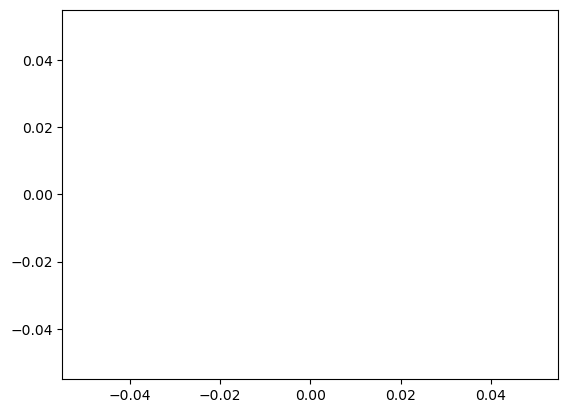

In [76]:
# FOR GT DATA

Layer_folder = "Layer_Data2/"
Data_folder = "Raw_Data2/"
labels_name = 'Layer_*.mat' 
data_name = "Data*.mat"

layer_pre ="Layer_Data2\\Layer_"
data_pre ="Raw_Data2\\"

Seg_feature_folder = "Seg_Featured_Data_Updated\\Seg_Featured_"



layer_fns = sorted(glob.glob(Layer_folder+labels_name))
data_fns = sorted(glob.glob(Data_folder+data_name))

# print(len(layer_fns), len(data_fns))
# Currently we have more raw data than picked layers - get the matching ones
data_fns_matching=[]
for df in data_fns:
    if layer_pre+df[len(data_pre):] in layer_fns:
        data_fns_matching.append(df)

# print(data_fns_matching[-7:], layer_fns[-7:])
# input("pasued")
# For each pair of Radar and Layer data
# progress = ""
# j = 0 
sectioned_data = []

# modby = np.ceil(len(data_fns_matching)/10)
for l, dat in zip(layer_fns[:], data_fns_matching[:]):
    print(l, dat)
    # Load the data
    layer_data = ndh.loadmat(l)
    radar_data = ndh.loadmat(dat)

    xy = ndh.polarstereo_fwd(radar_data['Latitude'][0],radar_data['Longitude'][0])
    distance = ndh.distance_vector(xy['x'],xy['y'])
    elevationdata = ndh.elevation_shift(radar_data['Data'],radar_data['Time'],radar_data['Surface'][0],radar_data['Elevation'][0],radar_data['Bottom'][0])
    log_data = np.log10(elevationdata['new_data']**2)

    a = 0
    b = log_data.shape[0]
    c = max(elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1])
    d = min(elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1])
    
    # Convert the labels nans to 0 and rotate so aligned
    layer_elevs = np.nan_to_num(layer_data['layer_info'][0][0][5], nan=0.0)
    rot_layer_elevs = np.rot90(layer_elevs, k=1)

    # print(layer_data['layer_info'][0][0][5].shape, layer_elevs.shape, rot_layer_elevs.shape)

    # Get the layers data
    GT_layers = getGTLayers(log_data, rot_layer_elevs, a, b, c, d)
    # print("gt_layers shape", GT_layers.shape)
    # break
    # print("seg imgs")
    # Segment the images
    window_sz = 250
    sectioned_data = []
    # sec_indexes = []
    stacked_dat =np.dstack((log_data, GT_layers))
    # print("stacked data shape", stacked_dat.shape)
    # plt.imshow(layer_elevs)
    # print(np.unique(GT_layers))
    i= 0 
    for r in range(0,stacked_dat.shape[0],window_sz):
        for c in range(0,stacked_dat.shape[1],window_sz):
            # cv2.imwrite(f"img{r}_{c}.png",img[r:r+30, c:c+30,:])
            if stacked_dat[r:r+window_sz, c:c+window_sz,1].any():
                # np.save("Seg_Data\\Seg_"+dat[len(data_pre):-len('.mat')]+"_"+str(i), stacked_dat[r:r+window_sz, c:c+window_sz,:])
                sectioned_data.append(stacked_dat[r:r+window_sz, c:c+window_sz,:])
                # sec_indexes.append([r,c])
                # getLayerOverlay(dat[len(data_pre):]+"_"+str(i), stacked_dat[r:r+window_sz, c:c+window_sz,0], stacked_dat[r:r+window_sz, c:c+window_sz,1], rot_layer_elevs)
                # break
                i +=1
    # print("len sec data: ",len(sectioned_data))
    # print("len sec indx: ",len(sec_indexes))
    # break
    # continue
    # For each segmented pices get the features
    i = 0
    progress = ""
    # for img, indx in zip(sectioned_data, sec_indexes):
    for img in sectioned_data:
        # print("geting feats")
        # print(img.shape)
        ld = img[:,:,0]
        layers = img[:,:,1]
        # break
        # n, layers_numbered = cv.connectedComponents(np.uint8(layers))
        connected_components, orientation, break_points, num_bp, dist_map, mean_orientation, splines,domains, X, Freq = getFeatures(np.uint8(layers))
        # print(type(connected_components[0]), type(orientation[0]), type(mean_orientation), type(break_points), type(dist_map), type(X), type(Freq))
        # print(connected_components[0].shape, orientation[0].shape, mean_orientation.shape, break_points.shape, dist_map.shape, len(X), len(Freq))

        # max_row,max_col= ld.shape
        max_row,max_col= (window_sz, window_sz)
        max_feats = len([0]*576+[0]*576+[0]*576+[0]*250*2+[0]*1) 

        # resized_cc = np.vstack((np.hstack((connected_components[0], np.zeros((connected_components[0].shape[0], max_col -connected_components[0].shape[1])))), np.zeros((max_row -connected_components[0].shape[0], max_col))))
        # resized_or = np.vstack((np.hstack((orientation[0], np.zeros((orientation[0].shape[0], max_col -orientation[0].shape[1])))), np.zeros((max_row -orientation[0].shape[0], max_col))))
        # resized_mo = np.vstack((np.hstack((mean_orientation, np.zeros((mean_orientation.shape[0], max_col -mean_orientation.shape[1])))), np.zeros((max_row -mean_orientation.shape[0], max_col))))
        resized_cc = connected_components[0].flatten()#.tolist()
        resized_or = orientation[0].flatten()#.tolist()
        resized_mo = mean_orientation.flatten()#.tolist()
        # resized_dm = dist_map.flatten()
        
        # print(len(X), len(Freq))
        max_freq = []
        max_f_c = 2
        for val, fr in zip(X, Freq):
            # print(len(val), len(fr))
            if len(val) < max_f_c:
                indices_max_f_c_largest = np.argpartition(val, -len(val))[-len(val):]
                # print(fr[indices_max_f_c_largest])
                # max_freq.append(fr[indices_max_f_c_largest])
                if fr[indices_max_f_c_largest][0] != np.inf and fr[indices_max_f_c_largest][0] != -np.inf: max_freq.append(fr[indices_max_f_c_largest][0])
                continue
            indices_max_f_c_largest = np.argpartition(val, -max_f_c)[-max_f_c:]
            # print(fr[indices_max_f_c_largest])
            if fr[indices_max_f_c_largest][0] != np.inf and fr[indices_max_f_c_largest][0] != -np.inf: max_freq.append(fr[indices_max_f_c_largest][0])
            if fr[indices_max_f_c_largest][1] != np.inf and fr[indices_max_f_c_largest][1] != -np.inf: max_freq.append(fr[indices_max_f_c_largest][1])
        

        # print(resized_cc.shape, resized_or.shape, resized_mo.shape, len(max_freq), num_bp,[num_bp])
        # print(len(resized_cc), len(resized_or), len(resized_mo), len(max_freq), num_bp, [num_bp])
        # print(type(max_freq), max_freq)
        # break
        # Save all the data in a numpy file
        # test = np.dstack((ld, layers, resized_cc, resized_or, resized_mo, break_points, dist_map, resized_X, resized_Fr))
        # t0 = resized_cc+resized_or+resized_mo+max_freq+[num_bp]
        # t0 = 
        # t0 = 
        # t0 = 
        t0= np.append(np.append(np.append(np.append(resized_cc, resized_or, axis=0),resized_mo), np.array(max_freq)), np.array([num_bp]))
        # print(type(t0), len(t0))
        # print(t0)
        test = np.array(t0)
        # print(len(test))
        if test.shape[0] < max_feats:
            test = np.hstack((test, np.zeros((max_feats-test.shape[0]))))
        # print(len(test))
        # print("Saving: "+Seg_feature_folder+dat[len(data_pre):-len('.mat')]+"_"+str(i))
        np.save(Seg_feature_folder+dat[len(data_pre):-len('.mat')]+"_"+str(i), test)
        i+=1
        
        if not i % len(sectioned_data)//10:
            progress += "#"
            print(progress)
    # break
    

In [60]:
# print(resized_cc.shape, resized_or.shape, resized_mo.shape, len(max_freq))
layer_data['layer_info'][0][0][5].shape , rot_layer_elevs.shape

((1732, 8), (8, 1732))

In [75]:
# np.load("Seg_Featured_Data_Updated\Seg_Featured_Data_20120330_01_004_0.npy", allow_pickle=True).shape

(2229,)

Seg_Data\Seg_Data_20120330_01_005_0.npy Data_20120330_01_005_0
labels:  1


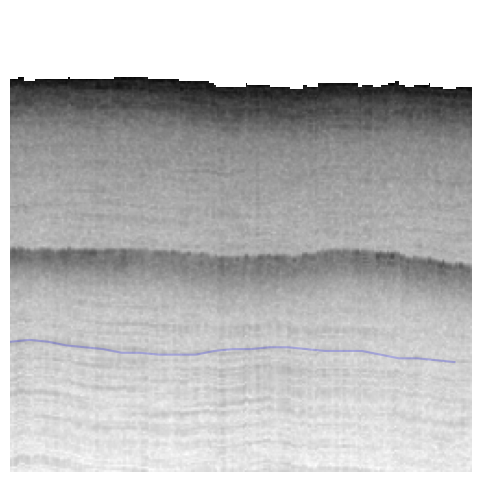

In [9]:
# Generates the segmented layer overlays from the segmented data created below.
fns =sorted(glob.glob("Seg_Data/*"))
len(fns)
window_sz = 30
r = 0
c = 0
i =0
for fn in fns[:1]:
    print(fn, fn[len("Seg_Data\Seg_"):-len('.npy')])
    test_load = np.load(fn, None, allow_pickle=True)
    getLayerOverlay(fn[len("Seg_Data\Seg_"):-len('.npy')], test_load[:,:,0], test_load[:,:,1])
    i+=1


(250, 250, 9)


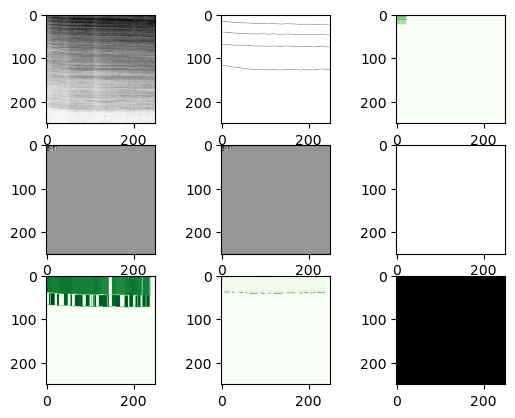

In [133]:
# Test save and display the labeled data
test_load = np.load("Seg_Featured_Data\Seg_Featured_Data_20120330_03_027_5.npy", None, allow_pickle=True)
print(test_load.shape)
d=0
fig, axs = plt.subplots(3,3)
maps = ['Greys', 'Greys', "Greens", "Greys", "Greys", "Greys", "Greens", "Greens", "Greys"]
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(test_load[:,:,d], maps[d]) 
        d +=1

3 3
['GT_Layers\\Data_20120330_01_004.mat', 'GT_Layers\\Data_20120330_03_026.mat', 'GT_Layers\\Data_20120330_03_028.mat'] ['GT_Layers\\Layer_Data_20120330_01_004.mat', 'GT_Layers\\Layer_Data_20120330_03_026.mat', 'GT_Layers\\Layer_Data_20120330_03_028.mat']
GT_Layers\Layer_Data_20120330_01_004.mat GT_Layers\Data_20120330_01_004.mat
8
[183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308
 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326
 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344
 345 34

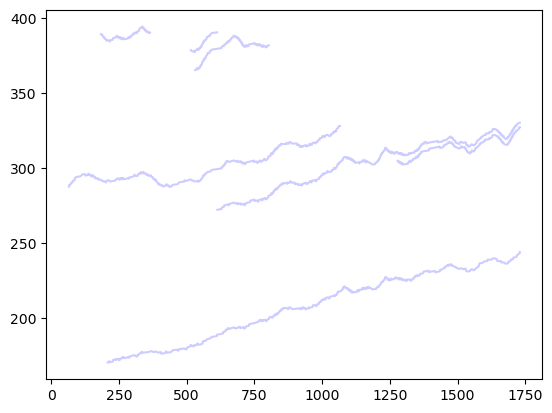

In [14]:
# Segment the data


# Layer_folder = "Layer_Data2/"
# Data_folder = "Raw_Data2/"
folder = 'GT_Layers/'
labels_name = 'Layer_*.mat' 
data_name = "Data*.mat"

layer_pre ="Layer_Data2\\Layer_"
data_pre ="Raw_Data2\\"


layer_fns = sorted(glob.glob(folder+labels_name))
data_fns = sorted(glob.glob(folder+data_name))

print(len(layer_fns), len(data_fns))
# Currently we have more raw data than picked layers - get the matching ones
# data_fns_matching=[]
# for df in data_fns:
#     if layer_pre+df[len(data_pre):] in layer_fns:
#         data_fns_matching.append(df)

print(data_fns, layer_fns)
# input("pasued")
i= 0 
# For each pair of Radar and Layer data
for l, dat in zip(layer_fns, data_fns):
    print(l, dat)
    # Load the data
    layer_data = ndh.loadmat(l)
    radar_data = ndh.loadmat(dat)

    xy = ndh.polarstereo_fwd(radar_data['Latitude'][0],radar_data['Longitude'][0])
    distance = ndh.distance_vector(xy['x'],xy['y'])
    elevationdata = ndh.elevation_shift(radar_data['Data'],radar_data['Time'],radar_data['Surface'][0],radar_data['Elevation'][0],radar_data['Bottom'][0])
    log_data = np.log10(elevationdata['new_data']**2)

    a = 0.0
    b = float(log_data.shape[0])
    c = max(elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1])
    d = min(elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1])
    
    # Convert the labels nans to 0 and rotate so aligned
    layer_elevs = np.nan_to_num(layer_data['layer_info'][0][0][5], nan=0.0)
    rot_layer_elevs = np.rot90(layer_elevs, k=1)

    # Get the layers data
    GT_layers = getGTLayers(log_data, rot_layer_elevs, a, b, c, d)

    break

    # This sections and saves the segmented images where layers are
    window_sz = 250
    sectioned_data = []

    stacked_dat =np.dstack((log_data, GT_layers))
    plt.imshow(stacked_dat[:,:,1])
    print(np.unique(GT_layers))
    i = 0
    for r in range(0,stacked_dat.shape[0],window_sz):
        for c in range(0,stacked_dat.shape[1],window_sz):
            # cv2.imwrite(f"img{r}_{c}.png",img[r:r+30, c:c+30,:])
            if stacked_dat[r:r+window_sz, c:c+window_sz,1].any():
                np.save("Seg_Data\\Seg_"+dat[len(data_pre):-len('.mat')]+"_"+str(i), stacked_dat[r:r+window_sz, c:c+window_sz,:])
                sectioned_data.append(stacked_dat[r:r+window_sz, c:c+window_sz,:])
                i +=1

    print(len(sectioned_data))

array([0.])

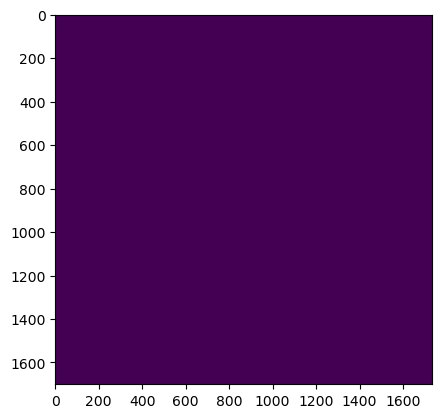

In [6]:
plt.imshow(GT_layers)
np.unique(GT_layers)
# layer_elevs.T[:5]

In [216]:
# This gets the splines for the whole GT layers image


## Get the equations for every layer in the image
# Calculate all the derivative of the splines
shift = 100
slice_labels = np.copy(GT_layers)# cv.connectedComponents(np.uint8(GT_layers))
label_values = np.unique(slice_labels)[1:] #remove the 0 label
num_labels = len(label_values)
splines = []
domains = []
derivs = []

print("labels: ", num_labels)#  n)

for label_num in label_values:
    # isolate the label and skeletonize so that label is 1
    label_skeleton = (slice_labels == label_num).astype(int)
    
    # Get every x,y every 10 columns
    row, col = label_skeleton.shape
    col_check = np.arange(0, col, 10)

    x, y = [], []
    for co in col_check:
        for r in range(row):
            if label_skeleton[r,co] == 1:
                if co in x: continue # if there are two lines then only take the top
                x.append(co) # get x indices
                y.append(r) # get y indices

    # create the cubic spline for the label
    if(len(x) > 1 and len(y) > 1):
        splines.append(CubicSpline(x,y))
        domains.append(x)
        derivs.append(splines[-1].derivative())

    # reset for next loop
    x = []
    y = [] 

labels:  34


In [227]:
surface_boarder = (a+(elevationdata['surface_elev']-c) * ( (b-a) / (d-c)))#.astype(int)
bedrock_boarder = (a+(elevationdata['bed_elev']-c) * ( (b-a) / (d-c)))#.astype(int)
a,b,c,d

(0.0, 1701.0, 2129.112038402035, -2656.7821994221267)

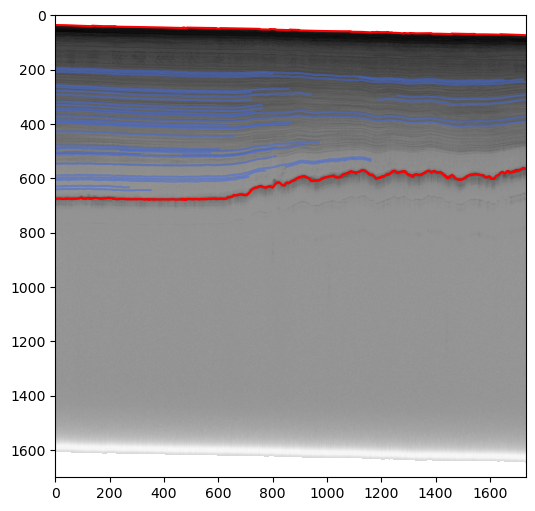

In [234]:
# display all splines
plt.close()
x = np.arange(0, GT_layers.shape[1], 10)
fig_cs, ax = plt.subplots(figsize=(9,6))
ax.imshow(log_data, cmap="binary")#, vmin=-50, vmax=-15) # if we want to see the image underneath
for i in range(len(domains)):
    ax.plot(domains[i], abs(splines[i](domains[i])), label = str(i), alpha=0.5, color='royalblue')

plt.plot(surface_boarder, color='r')
plt.plot(bedrock_boarder, color='r')

In [228]:
surface_boarder

array([35.54194714, 35.54246046, 35.54336937, ..., 72.70054179,
       72.74042966, 72.77961074])

In [229]:
bedrock_boarder

array([675.39376852, 675.39428184, 675.39519075, ..., 563.54082577,
       563.58071364, 563.61989471])

In [226]:
elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1], max(elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1])

(2129.112038402035, -2656.7821994221267, 2129.112038402035)

# For ML Output Images

they need to tell me what they shifted the raw data by to get the layers to align

In [9]:
import depth_shift

6 ['Layers_Data\\LAYERS-Data_20120418_01_042.mat', 'Layers_Data\\LAYERS-Data_20120516_01_081.mat', 'Layers_Data\\LAYERS-Data_20120516_01_082.mat', 'Layers_Data\\LAYERS-Data_20120516_01_088.mat', 'Layers_Data\\LAYERS-Data_20120516_01_089.mat', 'Layers_Data\\LAYERS-Data_20120516_01_090.mat']
6 ['Raw_Data\\Data_20120418_01_042.mat', 'Raw_Data\\Data_20120516_01_081.mat', 'Raw_Data\\Data_20120516_01_082.mat', 'Raw_Data\\Data_20120516_01_088.mat', 'Raw_Data\\Data_20120516_01_089.mat', 'Raw_Data\\Data_20120516_01_090.mat']
6 ['Raw_Data\\Data_20120418_01_042.mat', 'Raw_Data\\Data_20120516_01_081.mat', 'Raw_Data\\Data_20120516_01_082.mat', 'Raw_Data\\Data_20120516_01_088.mat', 'Raw_Data\\Data_20120516_01_089.mat', 'Raw_Data\\Data_20120516_01_090.mat']
Layers_Data\LAYERS-Data_20120418_01_042.mat Raw_Data\Data_20120418_01_042.mat
dict_keys(['__header__', '__version__', '__globals__', 'imlayer', 'labelayer', 'imamp', 'ysurface', 'ybottom'])
(1401, 1732) (1701, 1732) (1701, 1732)
[{'new_data': arra

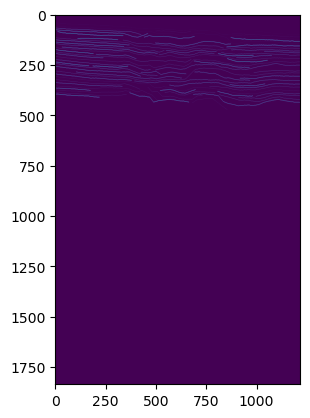

In [27]:
# Bayu
Layer_folder = "Layers_Data/"
Data_folder = "Raw_Data/"
labels_name = 'LAYERS-*.mat' 
layer_pre ="Layers_Data\\LAYERS-"
data_pre ="Raw_Data\\"

data_name = "Data*.mat"
Seg_feature_folder = "Seg_Featured_Data_Updated\\Bayu_Seg_Featured_"



layer_fns = sorted(glob.glob(Layer_folder+labels_name))
data_fns = sorted(glob.glob(Data_folder+data_name))

print(len(layer_fns), layer_fns)
print(len(data_fns), data_fns)
# Currently we have more raw data than picked layers - get the matching ones
data_fns_matching=[]
for df in data_fns:
    if layer_pre+df[len(data_pre):] in layer_fns:
        data_fns_matching.append(df)

print(len(data_fns_matching), data_fns_matching)

# input("pasued")
i= 0 
# For each pair of Radar and Layer data
for l, dat in zip(layer_fns, data_fns_matching):
    print(l, dat)
    # Load the data
    layer_data = ndh.loadmat(l)
    radar_data = ndh.loadmat(dat)

    print(layer_data.keys())

    xy = ndh.polarstereo_fwd(radar_data['Latitude'][0],radar_data['Longitude'][0])
    distance = ndh.distance_vector(xy['x'],xy['y'])
    elevationdata = ndh.elevation_shift(radar_data['Data'],radar_data['Time'],radar_data['Surface'][0],radar_data['Elevation'][0],radar_data['Bottom'][0])
    log_data = np.log10(elevationdata['new_data']**2)
    lay = np.copy(layer_data['imlayer'])
    lay = np.vstack((lay, np.zeros(( radar_data['Data'].shape[0] -lay.shape[0], lay.shape[1])))) # pad to the right size
    layerelevationdata = ndh.elevation_shift(lay,radar_data['Time'],radar_data['Surface'][0],radar_data['Elevation'][0],radar_data['Bottom'][0])


    print(layer_data['imlayer'].shape, log_data.shape, layerelevationdata['new_data'].shape)
    # break
    
    window_sz = 250
    sectioned_data = []

    stacked_dat =np.dstack((log_data, layerelevationdata['new_data']))
    plt.imshow(stacked_dat[:,:,1])
    print(np.unique(layerelevationdata))
    i = 0
    for r in range(0,stacked_dat.shape[0],window_sz):
        for c in range(0,stacked_dat.shape[1],window_sz):
            # cv2.imwrite(f"img{r}_{c}.png",img[r:r+30, c:c+30,:])
            if stacked_dat[r:r+window_sz, c:c+window_sz,1].any():
                np.save("Seg_Data\\Bayu_Seg_"+dat[len(data_pre):-len('.mat')]+"_"+str(i), stacked_dat[r:r+window_sz, c:c+window_sz,:])
                sectioned_data.append(stacked_dat[r:r+window_sz, c:c+window_sz,:])
                i +=1

    print(len(sectioned_data))

    # For each segmented pices get the features
    i = 0
    progress = ""
    for img in sectioned_data:
        
        ld = img[:,:,0]
        layers = img[:,:,1]

        connected_components, orientation, break_points, num_bp, dist_map, mean_orientation, splines,domains, X, Freq = getFeatures(np.uint8(layers))
        
        max_row,max_col= (window_sz, window_sz)
        max_feats = len([0]*576+[0]*576+[0]*576+[0]*250*2+[0]*1) 

        resized_cc = connected_components[0].flatten()#.tolist()
        resized_or = orientation[0].flatten()#.tolist()
        resized_mo = mean_orientation.flatten()#.tolist()
        
        max_freq = []
        max_f_c = 2
        for val, fr in zip(X, Freq):
            # print(len(val), len(fr))
            if len(val) < max_f_c:
                indices_max_f_c_largest = np.argpartition(val, -len(val))[-len(val):]
                # print(fr[indices_max_f_c_largest])
                # max_freq.append(fr[indices_max_f_c_largest])
                if fr[indices_max_f_c_largest][0] != np.inf and fr[indices_max_f_c_largest][0] != -np.inf: max_freq.append(fr[indices_max_f_c_largest][0])
                continue
            indices_max_f_c_largest = np.argpartition(val, -max_f_c)[-max_f_c:]
            # print(fr[indices_max_f_c_largest])
            if fr[indices_max_f_c_largest][0] != np.inf and fr[indices_max_f_c_largest][0] != -np.inf: max_freq.append(fr[indices_max_f_c_largest][0])
            if fr[indices_max_f_c_largest][1] != np.inf and fr[indices_max_f_c_largest][1] != -np.inf: max_freq.append(fr[indices_max_f_c_largest][1])
        

        t0= np.append(np.append(np.append(np.append(resized_cc, resized_or, axis=0),resized_mo), np.array(max_freq)), np.array([num_bp]))
        test = np.array(t0)
        # print(len(test))
        if test.shape[0] < max_feats:
            test = np.hstack((test, np.zeros((max_feats-test.shape[0]))))
        
        np.save(Seg_feature_folder+dat[len(data_pre):-len('.mat')]+"_"+str(i), test)
        i+=1
        
        if not i % len(sectioned_data)//10:
            progress += "#"
            print(progress)
    # break
    

Seg_Data\Bayu_Seg_Data_20120418_01_042_0.npy Data_20120418_01_042_0
labels:  21
Seg_Data\Bayu_Seg_Data_20120418_01_042_1.npy Data_20120418_01_042_1
labels:  16
Seg_Data\Bayu_Seg_Data_20120418_01_042_10.npy Data_20120418_01_042_10
labels:  26
Seg_Data\Bayu_Seg_Data_20120418_01_042_11.npy Data_20120418_01_042_11
labels:  24
Seg_Data\Bayu_Seg_Data_20120418_01_042_12.npy Data_20120418_01_042_12
labels:  26
Seg_Data\Bayu_Seg_Data_20120418_01_042_13.npy Data_20120418_01_042_13
labels:  17
Seg_Data\Bayu_Seg_Data_20120418_01_042_14.npy Data_20120418_01_042_14
labels:  16
Seg_Data\Bayu_Seg_Data_20120418_01_042_15.npy Data_20120418_01_042_15
labels:  21
Seg_Data\Bayu_Seg_Data_20120418_01_042_16.npy Data_20120418_01_042_16
labels:  21
Seg_Data\Bayu_Seg_Data_20120418_01_042_17.npy Data_20120418_01_042_17
labels:  13
Seg_Data\Bayu_Seg_Data_20120418_01_042_18.npy Data_20120418_01_042_18
labels:  7
Seg_Data\Bayu_Seg_Data_20120418_01_042_19.npy Data_20120418_01_042_19
labels:  17
Seg_Data\Bayu_Seg_Dat

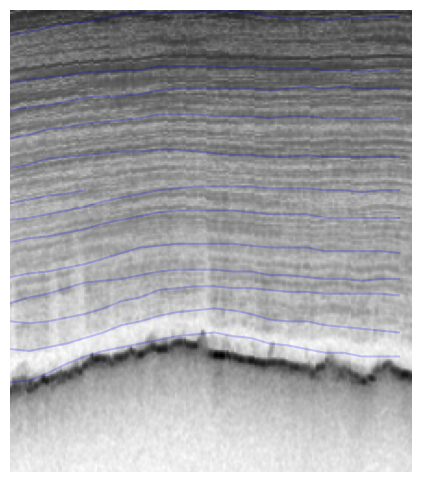

In [33]:
# Generates the segmented layer overlays from the segmented data created below.
fns =sorted(glob.glob("Seg_Data/Bayu*"))
len(fns)

window_sz = 30
r = 0
c = 0
i =0
for fn in fns[:]:
    print(fn, fn[len("Seg_Data\Bayu_Seg_"):-len('.npy')])
    test_load = np.load(fn, None, allow_pickle=True)
    getLayerOverlay(fn[len("Seg_Data\Bayu_Seg_"):-len('.npy')], test_load[:,:,0], test_load[:,:,1])
    i+=1


(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x113a29bbdc0>)

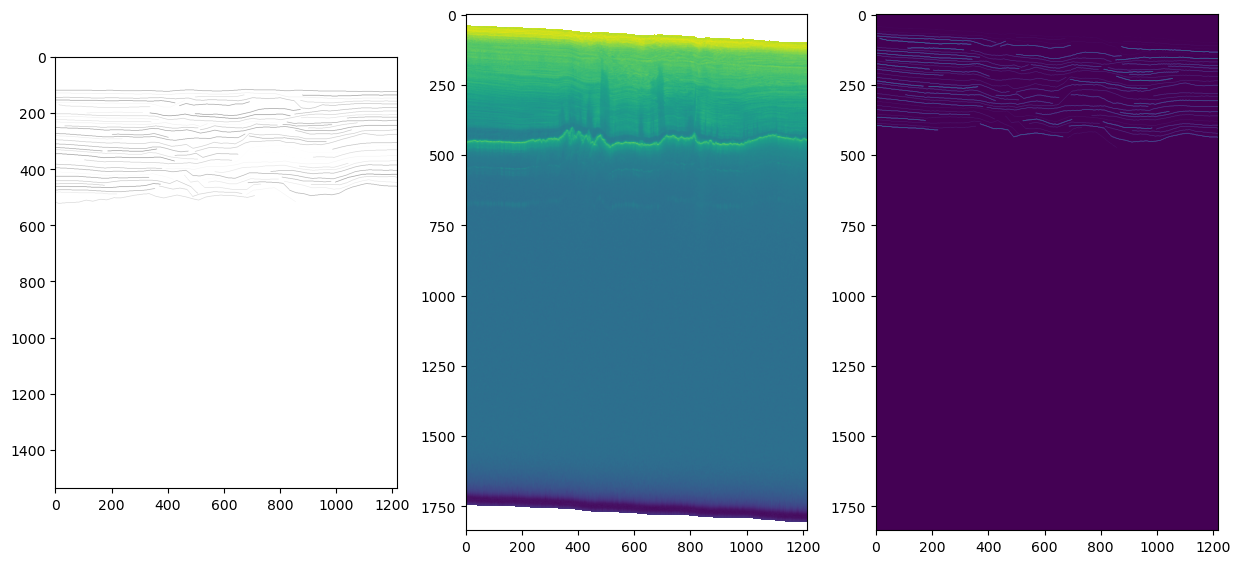

In [23]:
plt.figure(figsize=(15,20))
plt.subplot(131), plt.imshow(layer_data['imlayer']*100, cmap="binary")
plt.subplot(132), plt.imshow(np.log10(elevationdata['new_data']**2))
plt.subplot(133), plt.imshow(layerelevationdata['new_data'])


In [12]:
## Get the equations for every layer in the image
# Calculate all the derivative of the splines
# shift = 100
amp = layer_data['imamp']
# layer_data=layer_data['imlayer']

slice_labels = layer_data['imlayer']#layer_data[shift:,:]
label_values = np.unique(slice_labels)[1:] #remove the 0 label
num_labels = len(label_values)
splines = []
domains = []
derivs = []

print("labels: ", num_labels)

for label_num in label_values:
    # isolate the label and skeletonize so that label is 1
    label_skeleton = (slice_labels[:,:] == label_num).astype(int)
    
    # Get every x,y every 10 columns
    row, col = label_skeleton.shape
    col_check = np.arange(0, col, 10)

    x, y = [], []
    for c in col_check:
        for r in range(row):
            if label_skeleton[r,c] == 1:
                if c in x: continue # if there are two lines then only take the top
                x.append(c) # get x indices
                y.append(r) # get y indices

    # create the cubic spline for the label
    if(len(x) > 1 and len(y) > 1):
        splines.append(CubicSpline(x,y))
        domains.append(x)
        derivs.append(splines[-1].derivative())

    # reset for next loop
    x = []
    y = [] 



labels:  124


(-0.5, 1731.5, 1400.5, -0.5)

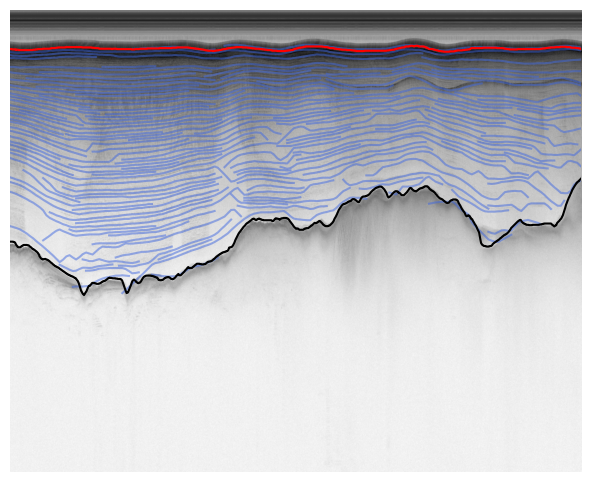

In [15]:
# display all splines
plt.close()
x = np.arange(0, amp.shape[1], 10)
fig_cs, ax = plt.subplots(figsize=(9,6))
ax.imshow(amp, cmap="binary")#, vmin=-50, vmax=-15) # if we want to see the image underneath
for i in range(len(domains)):
    ax.plot(domains[i], splines[i](domains[i]), label = str(i), alpha=0.5, color="royalblue")

ax.plot(np.arange(len(layer_data['ysurface'][0])), layer_data['ysurface'][0], label = 's', alpha=1.0, color="red")
ax.plot(np.arange(len(layer_data['ybottom'][0])), layer_data['ybottom'][0], label = 'b', alpha=1.0, color="black")
ax.axis('off')
# ax.legend()
# ax.invert_yaxis()

In [302]:
lay = np.copy(layer_data['imlayer'])
lay = np.vstack((lay, np.zeros(( radar_data['Data'].shape[0] -lay.shape[0], lay.shape[1]))))
print(radar_data['Data'].shape, lay.shape)
layerdepthdata = ndh.elevation_shift(lay,radar_data['Time'],radar_data['Surface'][0],radar_data['Elevation'][0],radar_data['Bottom'][0])
# layerdepthdata = depth_shift.depth_shift(layer_data['imlayer'],radar_data['Time'],radar_data['Surface'][0],radar_data['Elevation'][0],radar_data['Bottom'][0])

data = elevationdata
base = np.log10(data['new_data']**2)

a = 0
b = base.shape[0]
d = min(data['depth_axis'][0], data[ 'depth_axis'][-1])
c = max(data['depth_axis'][0], data[ 'depth_axis'][-1])

surface_boarder = np.rint((data['surface_elev']-c) * ( (b-a)/ (d-c))).astype(int)
bedrock_boarder = np.rint((data['bed_elev']-c) * ( (b-a)/ (d-c))).astype(int)

shift = bedrock_boarder - layer_data['ybottom'][0]
shift = surface_boarder - layer_data['ysurface'][0]

# a = 0
# b = base.shape[0]
# d = min(data['depth_axis'][0], data[ 'depth_axis'][-1])
# c = max(data['depth_axis'][0], data[ 'depth_axis'][-1])

slice_labels = layerdepthdata['new_data']#layer_data[shift:,:]
label_values = np.unique(slice_labels)[1:] #remove the 0 label
num_labels = len(label_values)
splines = []
domains = []
derivs = []

print("labels: ", num_labels)

for label_num in label_values:
    # isolate the label and skeletonize so that label is 1
    label_skeleton = (slice_labels[:,:] == label_num).astype(int)
    
    # Get every x,y every 10 columns
    row, col = label_skeleton.shape
    col_check = np.arange(0, col, 10)

    x, y, subshift = [], [], []
    for c in col_check:
        for r in range(row):
            if label_skeleton[r,c] == 1:
                if c in x: continue # if there are two lines then only take the top
                x.append(c) # get x indices
                y.append(r) # get y indices
                subshift.append(c)

    # create the cubic spline for the label
    if(len(x) > 1 and len(y) > 1):
        splines.append(CubicSpline(x,y))# +shift[subshift]))#((y-c) * ( (b-a)/ (d-c))))) #y ))#
        domains.append(x)
        # derivs.append(splines[-1].derivative())

    # reset for next loop
    x = []
    y = [] 
    subshift = [] 

# get surface spline 
surf_domain = np.arange(len(surface_boarder))
surf_spline = CubicSpline(surf_domain,surface_boarder)


# Get the bottom spline
bott_domain = np.arange(len(bedrock_boarder))
bott_spline = CubicSpline(surf_domain,bedrock_boarder)


(1701, 1732) (1701, 1732)
labels:  124


(-0.5, 1731.5, 1700.5, -0.5)

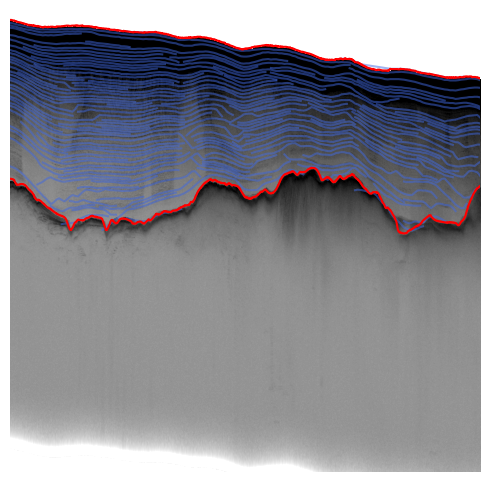

In [307]:
# display all splines
plt.close()
x = np.arange(0, base.shape[1], 10)
fig_cs, ax = plt.subplots(figsize=(9,6))
ax.imshow(base, cmap="binary", vmin=-40, vmax=-20) # if we want to see the image underneath
for i in range(len(domains)):
    ax.plot(domains[i], splines[i](domains[i]), label = str(i), alpha=0.5, color="royalblue")

ax.plot(np.arange(len(bedrock_boarder)), bedrock_boarder, label = 'b', alpha=1.0, color="red")
ax.plot(np.arange(len(surface_boarder)), surface_boarder, label = 's', alpha=1.0, color="red")

ax.axis('off')
# ax.legend()

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x21386ae1070>)

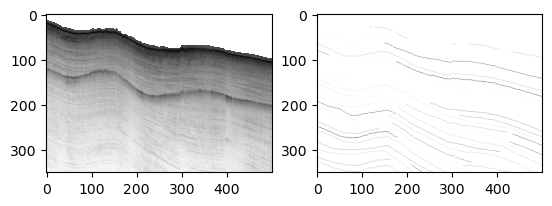

In [284]:
plt.subplot(121),plt.imshow(base[150:500,1100:1600], cmap="binary")#, vmin=-50, vmax=-15) # if we want to see the image underneath
plt.subplot(122),plt.imshow(layerdepthdata['new_data'][150:500,1100:1600], cmap='Greys')


In [285]:

slice_labels = layerdepthdata['new_data'][150:500,1100:1600]#layer_data[shift:,:]
label_values = np.unique(slice_labels)[1:] #remove the 0 label
num_labels = len(label_values)
splines = []
domains = []
derivs = []

print("labels: ", num_labels)

for label_num in label_values:
    # isolate the label and skeletonize so that label is 1
    label_skeleton = (slice_labels[:,:] == label_num).astype(int)
    
    # Get every x,y every 10 columns
    row, col = label_skeleton.shape
    col_check = np.arange(0, col, 10)

    x, y, subshift = [], [], []
    for c in col_check:
        for r in range(row):
            if label_skeleton[r,c] == 1:
                if c in x: continue # if there are two lines then only take the top
                x.append(c) # get x indices
                y.append(r) # get y indices
                subshift.append(c)

    # create the cubic spline for the label
    if(len(x) > 1 and len(y) > 1):
        splines.append(CubicSpline(x,y))# +shift[subshift]))#((y-c) * ( (b-a)/ (d-c))))) #y ))#
        domains.append(x)
        # derivs.append(splines[-1].derivative())

    # reset for next loop
    x = []
    y = [] 
    subshift = [] 

labels:  36


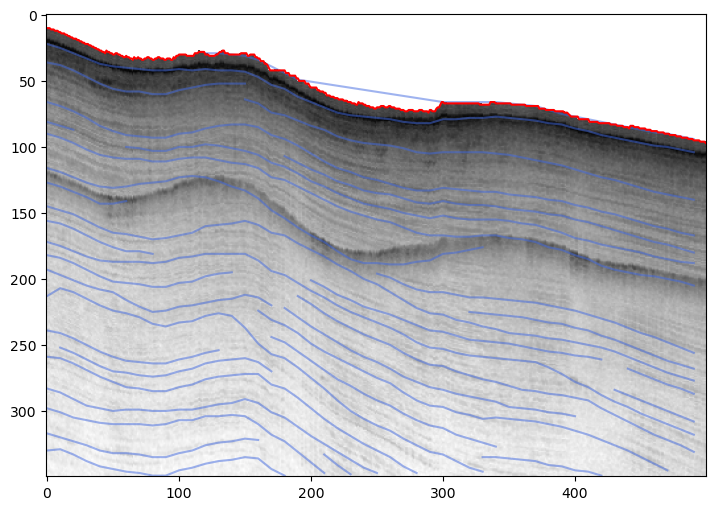

In [300]:
# display all splines
plt.close()
x = np.arange(0, base[150:500,1100:1600].shape[1], 10)
fig_cs, ax = plt.subplots(figsize=(9,6))
ax.imshow(base[150:500,1100:1600], cmap="binary")#, vmin=-50, vmax=-15) # if we want to see the image underneath
for i in range(len(domains)):
    ax.plot(domains[i], splines[i](domains[i]), label = str(i), alpha=0.5, color="royalblue")

# ax.plot(surf_domain, surf_spline(surf_domain), label = 's', alpha=1.0, color="red")
# ax.plot(bott_domain, bott_spline(bott_domain), label = 'b', alpha=1.0, color="black")
# ax.invert_yaxis()

# ax.plot(np.arange(len(layerdepthdata['bed_elev'])), layerdepthdata['bed_elev'], label = 'b', alpha=1.0, color="red")
# ax.plot(np.arange(len(surface_boarder)), layerdepthdata['surface_elev'], label = 's', alpha=1.0, color="black")

# ax.plot(np.arange(len(bedrock_boarder)), bedrock_boarder, label = 'b', alpha=1.0, color="red")
ax.plot(np.arange(len(surface_boarder))[:-1100+1600], surface_boarder[1100:1600]-np.min(surface_boarder[1100:1600]-10), label = 's', alpha=1.0, color="red")

# ax.axis('off')
# ax.legend()

In [ ]:
Layer_folder = "Layer_Data2/"
Data_folder = "Raw_Data2/"
labels_name = 'Layer_*.mat' 
data_name = "Data*.mat"

layer_pre ="Layer_Data2\\Layer_"
data_pre ="Raw_Data2\\"


layer_fns = sorted(glob.glob(Layer_folder+labels_name))
data_fns = sorted(glob.glob(Data_folder+data_name))

print(len(layer_fns), len(data_fns))
# Currently we have more raw data than picked layers - get the matching ones
data_fns_matching=[]
for df in data_fns:
    if layer_pre+df[len(data_pre):] in layer_fns:
        data_fns_matching.append(df)

print(data_fns_matching[-7:], layer_fns[-7:])
# input("pasued")
# For each pair of Radar and Layer data
# progress = ""
# j = 0 
# modby = np.ceil(len(data_fns_matching)/10)
for l, dat in zip(layer_fns[:], data_fns_matching[:]):
    print(l, dat)
    # Load the data
    layer_data = ndh.loadmat(l)
    radar_data = ndh.loadmat(dat)

    xy = ndh.polarstereo_fwd(radar_data['Latitude'][0],radar_data['Longitude'][0])
    distance = ndh.distance_vector(xy['x'],xy['y'])
    elevationdata = ndh.elevation_shift(radar_data['Data'],radar_data['Time'],radar_data['Surface'][0],radar_data['Elevation'][0],radar_data['Bottom'][0])
    log_data = np.log10(elevationdata['new_data']**2)

    a = 0
    b = log_data.shape[0]
    c = max(elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1])
    d = min(elevationdata['depth_axis'][0], elevationdata[ 'depth_axis'][-1])
    
    # Convert the labels nans to 0 and rotate so aligned
    layer_elevs = np.nan_to_num(layer_data['layer_info'][0][0][5], nan=0.0)
    rot_layer_elevs = np.rot90(layer_elevs, k=1)

    # Get the layers data
    GT_layers = getGTLayers(log_data, rot_layer_elevs, a, b, c, d)

    # Segment the images and calculate the features
    window_sz = 250
    sectioned_data = []

    stacked_dat =np.dstack((log_data, GT_layers))
    # plt.imshow(stacked_dat[:,:,1])
    # print(np.unique(GT_layers))
    i= 0 
    for r in range(0,stacked_dat.shape[0],window_sz):
        for c in range(0,stacked_dat.shape[1],window_sz):
            # cv2.imwrite(f"img{r}_{c}.png",img[r:r+30, c:c+30,:])
            if stacked_dat[r:r+window_sz, c:c+window_sz,1].any():
                np.save("Seg_Data\\Seg_"+dat[len(data_pre):]+"_"+str(i), stacked_dat[r:r+window_sz, c:c+window_sz,:])
                sectioned_data.append(stacked_dat[r:r+window_sz, c:c+window_sz,:])
                i +=1
    j+=1
    i = 0
    progress = ""
    for img in sectioned_data:
        ld = img[:,:,0]
        layers = img[:,:,1]
        # break
        n, layers_numbered = cv.connectedComponents(np.uint8(layers))
        connected_components, orientation, break_points, num_bp, dist_map, mean_orientation, splines,domains, X, Freq = getFeatures(np.uint8(layers_numbered))
        # print(type(connected_components[0]), type(orientation[0]), type(mean_orientation), type(break_points), type(dist_map), type(X), type(Freq))
        # print(connected_components[0].shape, orientation[0].shape, mean_orientation.shape, break_points.shape, dist_map.shape, X.shape, Freq.shape)

        max_row,max_col= ld.shape

        resized_cc = np.vstack((np.hstack((connected_components[0], np.zeros((connected_components[0].shape[0], max_col -connected_components[0].shape[1])))), np.zeros((max_row -connected_components[0].shape[0], max_col))))
        resized_or = np.vstack((np.hstack((orientation[0], np.zeros((orientation[0].shape[0], max_col -orientation[0].shape[1])))), np.zeros((max_row -orientation[0].shape[0], max_col))))
        resized_mo = np.vstack((np.hstack((mean_orientation, np.zeros((mean_orientation.shape[0], max_col -mean_orientation.shape[1])))), np.zeros((max_row -mean_orientation.shape[0], max_col))))
        # X = (np.array(X)).reshape(len(X), 1)
        resized_X = np.vstack((np.hstack((X, np.zeros((X.shape[0], max_col -X.shape[1])))), np.zeros((max_row -X.shape[0], max_col))))
        # Freq = (np.array(Freq)).reshape(len(Freq), 1)
        resized_Fr = np.vstack((np.hstack((Freq, np.zeros((Freq.shape[0], max_col -Freq.shape[1])))), np.zeros((max_row -Freq.shape[0], max_col))))

        # print(resized_cc.shape, resized_or.shape, resized_mo.shape, break_points.shape, dist_map.shape, resized_X.shape, resized_Fr.shape, GT_layers.shape)


        # break
        # Save all the data in a numpy file
        test = np.dstack((ld, layers, resized_cc, resized_or, resized_mo, break_points, dist_map, resized_X, resized_Fr))
        # print("Saving: Seg_Featured_Data\\Seg_Featured_"+dat[len(data_pre):-len('.mat')]+"_"+str(i))
        np.save("Seg_Featured_Data\\Seg_Featured_"+dat[len(data_pre):-len('.mat')]+"_"+str(i), test)
        i+=1
        
        if not i % len(sectioned_data)//10:
            progress += "#"
            print(progress)
    